Here let us show that fidelity of the wavefunction with all modes, and with only relevant modes, converges exponentially on the number of relevant modes $m\left(T\right)$

In [26]:
# import the required packages

import numpy as np
import lightcones.linalg as la
from lightcones import models
from lightcones.solvers.schrodinger import solve
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [19]:
n_sites = 20
# on-site energies
es = [1]*n_sites
# hoppings
hs = [0.05]*(n_sites-1)
H = la.tridiag(es, hs)

tmax = 100
dt = 0.01
t = np.arange(start = 0, stop = tmax, step = dt)
nt = t.size

phi_0 = np.zeros(n_sites, dtype = complex)
phi_0[0] = 1 # initially quantum is on the site 0

phi_lc = np.zeros((n_sites, nt), dtype = np.cdouble) # Here we store the propagated orbitals

def apply_h(ti, phi_in, phi_out):
    la.mv(H, phi_in, phi_out, cout=1)

def eval_o(ti, phi):
    phi_lc[:, ti] = phi
    
solve(0, nt-1, dt, apply_h, phi_0, eval_o = eval_o)

In [20]:
rho_lc = np.zeros((n_sites, n_sites), dtype = np.cdouble)

for i in range(0, nt):
    phi = la.as_column_vector(phi_lc[:, i])
    rho_lc += la.dyad(phi, phi) * dt

# for numerical stability, 
# it turns out necessary to explicity make it hermitean
# otherwise machine espilons will accumulate and break the hermicity
la.make_hermitean(rho_lc)

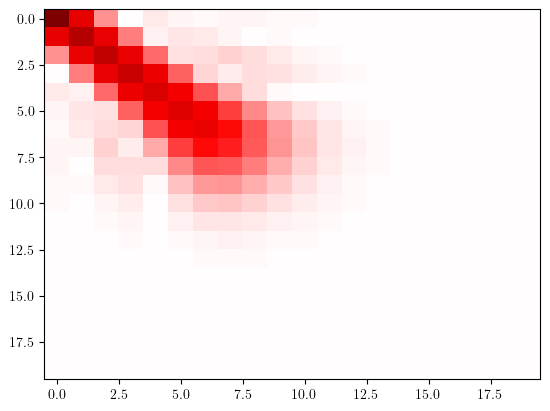

In [21]:
# Check for revival by plotting rho_lc 
max_ = np.max(np.abs(rho_lc))
plt.imshow(abs(rho_lc), aspect='auto', cmap = 'seismic', vmin = - max_, vmax = max_)
plt.show()

In [22]:
pi, U_rel = la.find_largest_eigs(rho_lc)

In [38]:
rel_tol = 10**(-6)
g_metric = pi - rel_tol * pi[0]
inside_lightcone = g_metric > 0
pi_rel = pi[inside_lightcone]
n_rel =  np.size(pi_rel)
print(str(n_sites) + " site are compressed to " + str(n_rel) + " relevant modes")

20 site are compressed to 8 relevant modes


In [37]:
# Recompute couplings 
couplings = U_rel.T.conj() @ phi_lc

In [27]:
# Solve non-stationary interaction-picture Schrodinger equation in the frame U_rel

# define the Hamiltonian of the spin-boson model

# number of boson chain modes
num_chain_modes = n_sites

# keep in the truncated Fock space only states in which 
# the bosonic chain has no more than max_num_quanta quanta
max_num_quanta = 5

# sparse matrices for the model
m = models.spin_boson(num_chain_modes, max_num_quanta)

# Hamitonian for the spin (qubit)
# Rabi (level splitting)
Omega = 2.0
Hs = m.s_p @ m.s_m * Omega / 2

# Coupling to the chain via raising / lowering Pauli matrices
# coupling strength g
g = 0.05

def Hint(ti):
    V = g * m.s_m @ sum(couplings[:, ti] * m.a_dag)
    V_dag = V.T.conj()
    return V + V_dag

# The qubit is periodically driven
def drive(t):
    return(0.1*np.cos(t)) * m.s_x

# The Hamiltonian for the driven spin-boson model
def Hsb_driven(ti):
    return Hs + drive((ti + 0.5)*dt) + Hint(ti)

In [28]:
# The non-stationary Schrodinger equation is solved on a time grid
# [0    dt    2*dt    ...    k*dt  ... ]
# The time grid points are numbered by integer ti
# [0    1     2       ....   k     ... ]
# The time-dependent Hamiltonian is invoked by the solver with ti argument,
# and the corresponding time moment is (ti + 0.5)*dt
# Here 0.5*dt is due to the midpoint integration rule

# Initialize Hamiltonian at the beginning of a new time step
Hti = None
def begin_step(ti, psi):
    global Hti
    Hti = Hsb_driven(ti)

# Callback function which applies Hamiltonian to the wavefunction at each time grid point ti
def apply_h(ti, psi_in, psi_out):
    la.mv(Hti, psi_in, psi_out, cout=1)
    
# initial condition:
# vacuum state for bosonic chain,
# and ground state for spin (qubit)
psi_0 = np.zeros(m.dimension, dtype = complex)
psi_0[0] = 1.0 
    
# Here the current wavefunction is stored
psi = np.zeros(m.dimension, dtype = complex)
    
# Solve the non-stationary Schrodinger equation
solve(0, nt-1, dt, apply_h, psi_0, begin_step = begin_step, psi = psi)

In [33]:
# In order to compute fidelity, the wavefunction should be properly normalized
psi_full = np.copy(psi) / np.sqrt(np.vdot(psi, psi))

In [43]:
# Now repeat the same calculation keeping only first n_modes relevant modes

def only_first_modes(n_modes):
    def Hint(ti):
        V = g * m.s_m @ sum(couplings[: n_modes, ti] * m.a_dag[: n_modes])
        V_dag = V.T.conj()
        return V + V_dag
    def Hsb_driven(ti):
        return Hs + drive((ti + 0.5)*dt) + Hint(ti)
    only_first_modes.Hti = None
    def begin_step(ti, psi):
        only_first_modes.Hti = Hsb_driven(ti)
    def apply_h(ti, psi_in, psi_out):
        la.mv(only_first_modes.Hti, psi_in, psi_out, cout=1)
    psi = np.zeros(m.dimension, dtype = complex)
    solve(0, nt-1, dt, apply_h, psi_0, begin_step = begin_step, psi = psi)
    return psi

In [47]:
psi_rst = []

for i in range(1, n_rel):
    psi_ = only_first_modes(i)
    psi_ = np.copy(psi_) / np.sqrt(np.vdot(psi_, psi_))
    psi_rst.append(psi_)

In [48]:
# infidelities
I = []
for psi_ in psi_rst:
    I_ = 1 - np.abs(np.vdot(psi_, psi_full))
    I.append(I_)
I

[0.0009831775760319461,
 0.0008130383811892905,
 0.00043526159455664626,
 6.024324719255958e-05,
 2.6259159044972336e-06,
 1.3267628662383402e-07,
 5.429258931322067e-09]

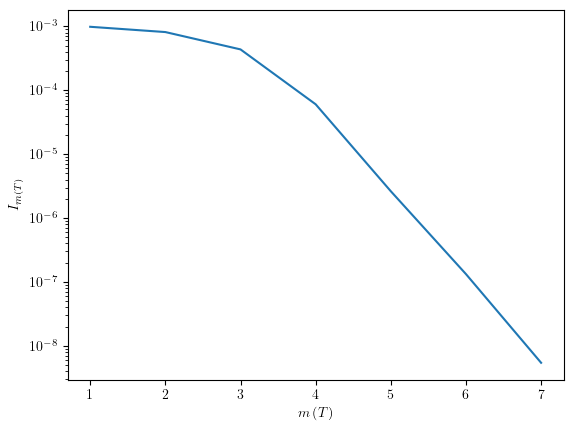

In [51]:
# Let us plot the convergence of wavefunction with respect to number of kept relevant modes:
plt.plot(np.array(range(1, n_rel)), np.array(I))
plt.yscale('log')
plt.xlabel(r"$m\left(T\right)$")
plt.ylabel(r"$I_{m\left(T\right)}$")
plt.savefig('I_rel.eps', format='eps')